# Implementación de *Simulated Annealing* para el problema del agente viajero

**Importar las librerías necesarias para poder trabajar con los datos**

In [1]:
import pandas as pd
import numpy as np
from numpyencoder import NumpyEncoder
import matplotlib.pyplot as plt
import os
import json

**Leer los datos (la matriz de distancias) y crear un DataFrame a partir de ellos**

In [2]:
CITIES = np.empty((128, 3))

with open('coordinates.txt', 'r') as f:
    for index, line in enumerate(f.readlines()):
        line = line.strip().split()
        CITIES[index] = [index, float(line[0]), float(line[1])]

DATA = pd.read_csv('cities.csv', header=None)

# Vamos a imprimir los primeros 5 para asegurarnos de que todo está bien
DATA.head(5)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0,966,1513,2964,1149,927,1611,1510,390,466,...,1018,168,565,1700,1636,2019,1458,1564,2871,348
1,966,0,2410,1520,1817,729,686,290,1823,168,...,548,1127,432,2265,558,571,943,198,1917,2541
2,1513,2410,0,604,481,2742,1833,826,214,1618,...,752,486,590,2132,1095,2154,1211,2217,2673,1570
3,2964,1520,604,0,595,1289,1446,466,1139,430,...,1861,861,499,1408,986,2719,1437,769,1038,2343
4,1149,1817,481,595,0,494,550,2641,765,934,...,216,1994,324,2187,260,2586,1974,2352,2243,691


**Hacer un primer camino aleatorio**

In [3]:
PATH = np.random.permutation(CITIES)

**Definir la función del costo del camino actual**

In [4]:
def cost(path: np.array) -> float:
    """Calcula el costo de la ruta elegida al momento

    Args:
        path (np.array): Array que contiene la ruta que se debe de seguir al momento

    Returns:
        float: El costo de la ruta
    """
    global DATA
    
    cost = 0
    
    # Calcular el costo del camino
    for i in range(len(path) - 1):
        cost += DATA.iloc[int(path[i, 0]), int(path[i + 1, 0])]
        
    # Sumar el costo de volver al principio
    cost += DATA.iloc[int(path[-1, 0]), int(path[0, 0])]
    return cost

**Definir la función de obtener un nuevo camino 'vecino' del actual**

In [5]:
def generate_path(path: np.array) -> np.array:
    """Genera una ruta tomando dos elementos aleatorios de la ruta, y haciendo un 'reverse' de todos los elementos 
        dentro del array formado por estas dos ciudades como extremos

    Args:
        path (np.array): La ruta actual

    Returns:
        np.array: La nueva ruta
    """
    # Tomar dos elementos aleatorios
    i, j = np.random.choice([i for i in range(0, 128)], size=2, replace=False)
    
    # Hacer el swap
    new_path = np.copy(path)
    new_path[i : j] = path[i : j][::-1]
    
    return new_path

## Función que usa todas las funciones anteriores para generar la mejor ruta

In [6]:

def simulated_annealing(path: np.array, t: float, l: int, max_loops: int = 2000000, t_update: float = 0.999, save_graph_values: bool = True) -> list:
    """Función que implementa el algoritmo de Simulated Annealing

    Args:
        path (np.array): La ruta actual
        t (float): Temperatura
        l (int): Cada cuantas iteraciones se debe de actualizar la temperatura
        max_loops (int, optional): Cantidad máxima de iteraciones. Defaults to 1000000.
        t_update (float, optional): Factor de actualización de la temperatura. Defaults to 0.99.

    Returns:
        np.array: La nueva ruta
    """
    diff = 0
    k = 0
    cost_path = cost(path)
    super_min_cost = cost_path
    results = []
    t_values = []
    information = {
        'T': t,
        'L': l,
        't_update': t_update,
        'max_loops': max_loops,
        'paths': [
            path
        ]
    }

    while k < max_loops:
        # Generar una nueva ruta
        new_path = generate_path(path)

        # Calcular la diferencia de costos
        cost_new_path = cost(new_path)
        diff = cost_new_path - cost_path
        
        # Calcular el minimo costo que se ha tenido en todas las corridas y si es menor que el actual actualizar la información
        if cost_new_path < super_min_cost:
            super_min_cost = cost_new_path
            information['paths'].append(new_path)

        # Si la diferencia es menor que 0, entonces la nueva ruta es mejor, por lo que la actual se debe de actualizar
        if diff < 0:
            path = new_path
            cost_path = cost_new_path

        # Si la diferencia es mayor que 0, entonces la nueva ruta es peor, por lo que se debe de probar si debe de ser aceptada
        elif np.random.rand() < np.exp(-diff / t):
            path = new_path
            cost_path = cost_new_path

        # Escribir el costo dentro del array de resultados y T para graficar
        results.append(cost_path)
        t_values.append(t)

        # Aumentar K y cada L pasos disminuir T
        k += 1
        if k % l == 0:
            t *= t_update
            
            
    # Guardar la información dentro de un archivo
    if save_graph_values:
        with open(f'files/SA_t={t}_l={l}_tupdate={t_update}_d={results[-1]}_02.json', 'w') as file:
            json.dump(information, file, indent=0, sort_keys=True,separators=(',', ':'), ensure_ascii=False, cls=NumpyEncoder)
    
    return results, t_values, super_min_cost
    
    

**Ejecutar el programa**

Después de jugar varias veces con las variables, se encontró que con las siguientes era de las mejores soluciones que daba el programa

In [7]:
execute = True
save_graph = False

# seed = np.random.randint(0, 1000000000)
# print(f"seed: {seed}")
seed = 698133137
np.random.seed(seed)

if execute:
    T = 3000
    l = 100
    t_update = 0.997
    max_loops = 100000

    # run algorithm
    results, t_values, min_cost = simulated_annealing(path=PATH, t=T, l=l, max_loops=max_loops, t_update=t_update, save_graph_values=True)

    # graph results
    if save_graph:
        plt.figure(figsize=(8,6), facecolor='w')
        plt.plot(range(len(results)), results)
        plt.title(f'Cost of Simulated Annealing with T={T}. min={min_cost}')
        plt.xlabel('k iterations')
        plt.ylabel('Cost')

        # save plot on disk
        plt.savefig(f'./plots/SA_t={T}_l={l}_tupdate={t_update}_s={seed}_d={results[-1]}_min={min_cost}.png')
        plt.clf()

        ########################
        # graph results
        plt.plot(range(len(t_values)), t_values)
        plt.title(f'Value of T')
        plt.xlabel('k iterations')
        plt.ylabel('T')

        # save plot on disk
        plt.savefig(f'./plots/T_t={T}_l={l}_tupdate={t_update}_s={seed}_d={results[-1]}_min={min_cost}.png')
        plt.clf()
    
    print(f"Finished with min_cost: {min_cost}")

Finished with min_cost: 38328


Después de varias corridas, nos damos cuenta de que el mejor resultado es el siguiente: ```135,434``` km.

Sin embargo, se logró cuando todavía no guardaba ni el *seed* ni la información de las corridas para poder efectuar la animación, es por eso que la animación se hará con otra corrida. Sin embargo, las variables fueron las siguientes en la mejor corrida: ```(T=3000, L=100, t_update=0.997)```, y en esa corrida si se guardó la gráfica que es la siguiente:

<img src="plots/SA_t=3000_l=100_tupdate=0.997_d=135434.png"/>

La animación de la corrida se hará con los datos de una corrida con los mismos valores ```(T=3000, L=100, t_update=0.997, seed=698133137)``` pero que tuvo un costo de ```136,570``` km, solo ```1,136``` km más que la mejor (un incremento del 0.8% que puede despreciarse). La gráfica del costo de dicha corrida es la siguiente:

<img src="plots/SA_t=3000_l=100_tupdate=0.997_s=698133137_d=136570_min=136570.png"/>

Además, podemos graficar cuál es el decremento de T conforme avanza el tiempo (conforme k va creciento). Lo podemos ver en la siguiente gráfica (valores ```T=2000, L=100, t_update=0.998, max_loops=100000```):

<img src="plots/T_t=2000_l=100_tupdate=0.998_maxloops=100000.png"/>




## Animación

**Primero vamos a graficar todas las coordenadas**

In [8]:
COORDS = np.empty((128, 2))

with open('coordinates.txt', 'r') as f:
    for index, line in enumerate(f.readlines()):
        line = line.strip().split()
        COORDS[index] = [float(line[0]), float(line[1])]

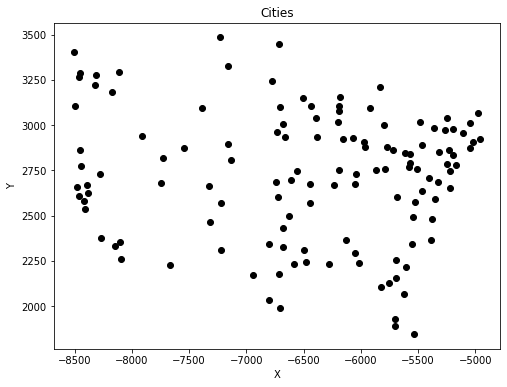

In [9]:
plt.figure(figsize=(8,6), facecolor='w')

plt.plot(COORDS.T[0], COORDS.T[1], 'o', c='black')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Cities")

plt.savefig(f'./map.png')
plt.show()

**Ahora vamos a crear todos los plots y guardarlos como imagenes para poderlas juntar después como una visualización de animación**

In [12]:
# Declarar la variable que va a guardar toda la información
information = {}

# Leer el archivo que resultó con toda la información de la corrida
with open('./files/SA_t=3000_l=100_tupdate=0.997_d=39839_02.json', 'r') as file:
    information = json.load(file)
    
paths = np.array(information['paths'])
for i in range(len(paths)):
    plt.figure(figsize=(8,6), facecolor='w')
    plt.plot(paths[i, :, 1], paths[i, :, 2], '-o')
    plt.title(f'step: {i}.  Cost: {cost(paths[i, :, :])}')
    plt.xlabel('X')
    plt.ylabel('Y')

    # save plot on disk
    # plt.savefig(f'./plots/animation/{i}.png')
    # plt.show()
    # plt.clf()

/var/folders/vq/wth7jk_x3mq0j1hftwhfgmm00000gp/T/ipykernel_72924/142862502.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,6), facecolor='w')
